In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from Energy.Models.Model1 import model1
from Energy.Models.Model2 import model2

# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


If needed: Fetch energy-data first

In [3]:
# from Energy.HelpFunctions.get_energy_data import fetch_energy_data
# fetch_energy_data()

In [6]:
df = get_energy_data()
df = prepare_data(df)

# Cross validate baseline model

Remove everything til last thursday night 12pm

In [7]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [6]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)        
        
        pred = None     
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before)
               
        
        obs = pd.DataFrame({'gesamt': df.loc[pred['forecast_date']]["gesamt"]})
        pred = pred.set_index('forecast_date')
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['gesamt']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    return evaluation

## Evaluation of selected Models

In [4]:
from Energy.Models.Model3 import model3

models = [
    {
        'name': 'MM_baseline_model3',
        'function': [[baseline, model1],[0.5,0.5]]
    },
    {
        'name': 'baseline',
        'function': baseline
     },
    # {
    #     'name': 'model1',
    #     'function': model1
    # },
    # {
    #     'name': 'model2',
    #     'function': model2
    # },
    {
        'name': 'model3',
        'function': model3
    },
    
]

start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

NameError: name 'df' is not defined

In [8]:
evaluate_models(models, df_cval, last_x=100, weeks=True)

*********** Start the evaluation of Model MM_baseline_model3 ***********
Iteration 0 of 100
Iteration 1 of 100
Iteration 2 of 100
Iteration 3 of 100
Iteration 4 of 100


KeyboardInterrupt: 

### Save evaluations in pkl file

In [34]:
with open('./Model evaluations/bl_m3_MM-bl-m3.pkl', 'wb') as f:
    pickle.dump(models, f)

# with open('model_evaluations.pkl', 'rb') as f:
#     models = pickle.load(f)

### Create a table that only contains the different scores of the different models

In [27]:
# scores = [m['evaluation']['score'][m['evaluation']['horizon'] == '36 hour'] for m in models]
# horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
# 
# 
# names = [m['name'] for m in models]
# score_df = pd.concat(scores, axis=1,keys=names)

In [35]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)

        

In [36]:
score_df

,MM_baseline_model3: 36 hour,baseline: 36 hour,model3: 36 hour,MM_baseline_model3: 40 hour,baseline: 40 hour,model3: 40 hour,MM_baseline_model3: 44 hour,baseline: 44 hour,model3: 44 hour,MM_baseline_model3: 60 hour,baseline: 60 hour,model3: 60 hour,MM_baseline_model3: 64 hour,baseline: 64 hour,model3: 64 hour,MM_baseline_model3: 68 hour,baseline: 68 hour,model3: 68 hour
forecast_date,,,,,,,,,,,,,,,,,,
2021-12-17 12:00:00,0.007286,0.008565,0.005572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 16:00:00,NaN,NaN,NaN,0.008063,0.016106,0.004003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.007728,0.009011,0.006024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-18 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016886,0.019792,0.013974,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-18 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020716,0.031628,0.011859,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-10 16:00:00,NaN,NaN,NaN,0.004690,0.009061,0.010736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-10 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.005013,0.006471,0.007000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-11 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004641,0.005362,0.007158,NaN,NaN,NaN,NaN,NaN,NaN


### Plot the densities of the obtained scores

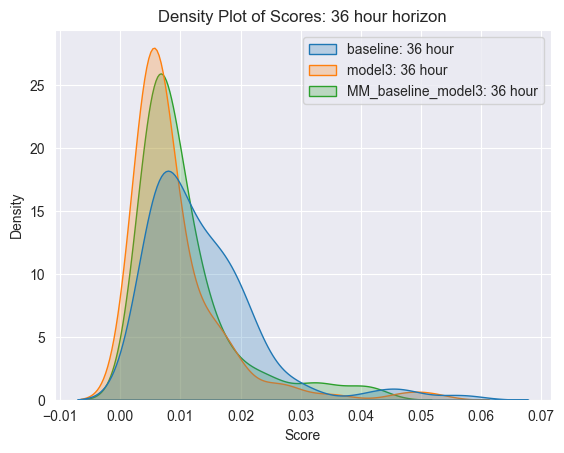

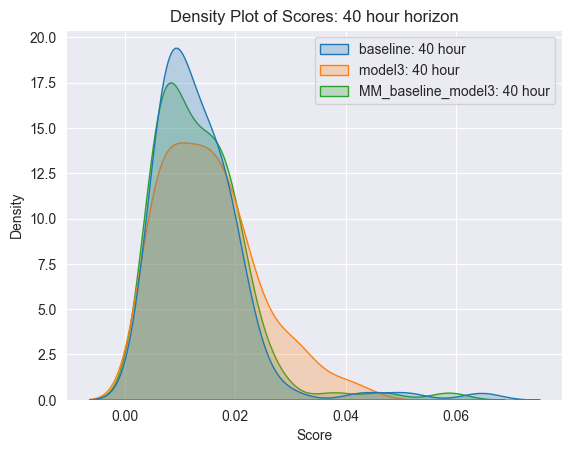

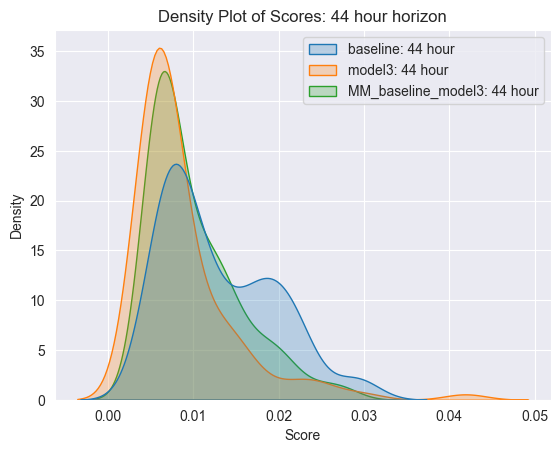

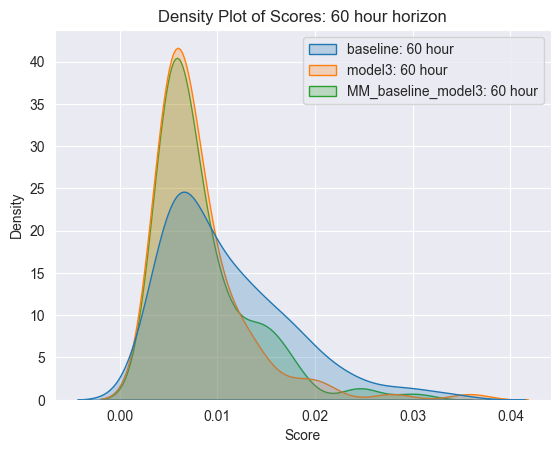

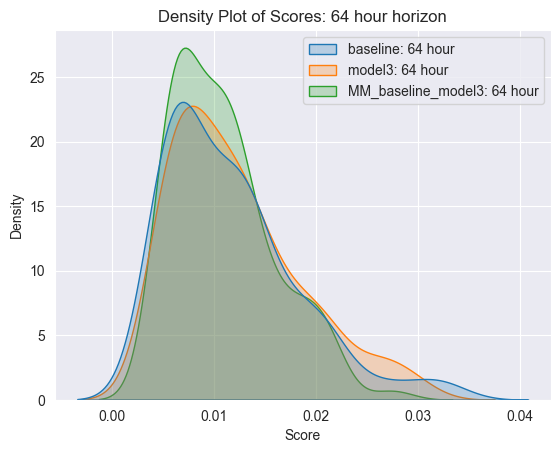

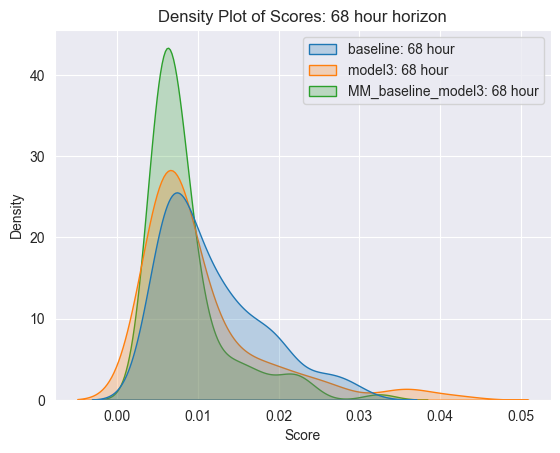

In [38]:
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    sns.kdeplot(data=score_df.loc[:,[f'baseline: {h}',f'model3: {h}',f'MM_baseline_model3: {h}']], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')
    
    # Display the plot
    plt.show()

In [ ]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['baseline: 36 hour'].notna()]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
plt.plot(score_df_36_no_na.index, score_df_36_no_na['model1: 36 hour'], label='model1')
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['model2: 36 hour'], label='model2')
plt.plot(score_df_36_no_na.index, score_df_36_no_na['model3: 36 hour'], label='model3')


# Adding labels and title
plt.xlabel('time')
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [28]:
mix_models([baseline2, model3], [1,1],df_cval)

[Timestamp('2023-11-17 12:00:00'), Timestamp('2023-11-17 16:00:00'), Timestamp('2023-11-17 20:00:00'), Timestamp('2023-11-18 12:00:00'), Timestamp('2023-11-18 16:00:00'), Timestamp('2023-11-18 20:00:00')]
        forecast_date  target  horizon     q0.025      q0.25       q0.5  \
0 2023-11-17 12:00:00  energy  36 hour  53.274763  60.869062  63.552250   
1 2023-11-17 16:00:00  energy  40 hour  50.642019  55.801063  58.491375   
2 2023-11-17 20:00:00  energy  44 hour  49.348806  52.409875  56.135375   
3 2023-11-18 12:00:00  energy  60 hour  47.477200  51.317125  53.837750   
4 2023-11-18 16:00:00  energy  64 hour  44.081156  47.397937  50.045750   
5 2023-11-18 20:00:00  energy  68 hour  43.284444  46.351937  49.405625   

       q0.75     q0.975  
0  66.894750  74.963481  
1  62.676437  70.579475  
2  59.975938  67.135544  
3  57.222375  63.336100  
4  53.217188  61.228112  
5  53.132812  59.913819  


,forecast_date,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-17 12:00:00,36 hour,54.280381,62.274779,65.451004,68.761376,75.145365
1,2023-11-17 16:00:00,40 hour,52.964009,59.740779,62.920567,66.652220,72.953362
2,2023-11-17 20:00:00,44 hour,48.792654,54.341812,58.162066,61.746969,67.979397
3,2023-11-18 12:00:00,60 hour,45.926100,52.332810,55.698781,59.195690,64.591801
4,2023-11-18 16:00:00,64 hour,44.228078,50.373217,53.802781,57.193096,63.537807
5,2023-11-18 20:00:00,68 hour,40.304972,46.146843,49.902218,53.595908,59.628660


In [25]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns


# Expected a prepared df (date, gesamt). Calculates the baseline-predictions for the next [36, 40, 44, 60, 64, 68]h
# Offtest the data by LAST_IDX
def baseline2(df, LAST_IDX=-1):
    horizons_def = [36, 40, 44, 60, 64, 68]  # [24 + 12*i for i in range(5)]
    horizons = [h + 1 for h in horizons_def]
    LAST_DATE = df.iloc[LAST_IDX].name
    horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons]
    
    print(horizon_date)
    tau = [.025, .25, .5, .75, .975]
    pred_baseline = np.zeros((6, 5))
    last_t = 100
    for i, d in enumerate(horizon_date):
        weekday = d.weekday()
        hour = d.hour

        df_tmp = df.iloc[:LAST_IDX]

        cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())

        pred_baseline[i, :] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)

    df_sub = pd.DataFrame({
        "forecast_date": horizon_date,
        "target": "energy",
        "horizon": [str(h) + " hour" for h in horizons_def],
        "q0.025": pred_baseline[:, 0],
        "q0.25": pred_baseline[:, 1],
        "q0.5": pred_baseline[:, 2],
        "q0.75": pred_baseline[:, 3],
        "q0.975": pred_baseline[:, 4]})
    return df_sub



def get_date_from_horizon(last_ts, horizon):
    return last_ts + pd.DateOffset(hours=horizon)

In [34]:
# from HelpFunctions.mix_models import mix_models as mm
# 
# import importlib
# importlib.reload(Energy.Models)


from importlib import reload
from HelpFunctions import mix_models as mms
reload(mms)

mms.mix_models_per_horizon([baseline, model3, baseline], [[ 1,1,0,0,0,0], [0,0,1,1,0,0], [0,0,0,0,1,1]], df)

      q0.025      q0.25       q0.5      q0.75     q0.975
0  36.480331  49.334625  52.745375  56.716188  64.100206
1  46.431225  59.901187  63.500375  66.641500  74.255831
2  44.014931  58.826563  62.496250  64.807938  72.400681
3  46.230925  51.559812  54.495750  58.242562  65.002375
4  56.585844  61.288687  63.878750  67.096375  74.018488
5  54.953562  59.561563  62.233375  65.411125  71.820200
      q0.025      q0.25       q0.5    q0.75     q0.975
0  48.260251  56.271000  60.148756  63.4895  68.808500
1  55.292751  63.685879  67.307506  70.5930  75.314751
2  55.292751  63.685879  67.307506  70.5930  75.314751
3  48.260251  56.271000  60.148756  63.4895  68.808500
4  55.292751  63.685879  67.307506  70.5930  75.314751
5  55.292751  63.685879  67.307506  70.5930  75.314751
      q0.025      q0.25       q0.5      q0.75     q0.975
0  36.480331  49.334625  52.745375  56.716188  64.100206
1  46.431225  59.901187  63.500375  66.641500  74.255831
2  44.014931  58.826563  62.496250  64.807938

,forecast_date,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-27 06:00:00,36 hour,36.480331,49.334625,52.745375,56.716188,64.100206
1,2023-11-27 10:00:00,40 hour,46.431225,59.901187,63.500375,66.641500,74.255831
2,2023-11-27 14:00:00,44 hour,55.292751,63.685879,67.307506,70.593000,75.314751
3,2023-11-28 06:00:00,60 hour,48.260251,56.271000,60.148756,63.489500,68.808500
4,2023-11-28 10:00:00,64 hour,56.585844,61.288687,63.878750,67.096375,74.018488
5,2023-11-28 14:00:00,68 hour,54.953562,59.561563,62.233375,65.411125,71.820200
